In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from fund.fund import Fund

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
market = Market()

In [3]:
delta_fund = Fund()
delta_fund.initialize()

In [4]:
market.connect()
sp100 = market.retrieve("sp100")
market.disconnect()

In [5]:
analysis = []
for strategy in tqdm(delta_fund.strategies):
    try:
        parameters = strategy.pull_iterations().to_dict("records")
        for parameter in tqdm(parameters):
            try:
                trade = strategy.db.query("trades",{"iteration":parameter["iteration"]})
                if trade.index.size > 0:
                    positions = int(strategy.positions) if strategy.pricer_class.asset_class.value == "stocks" else 1
                    pricer_timeframe =  strategy.pricer_class.time_horizon_class.naming_convention
                    trade = trade[trade["position"] <= positions]
                    ledger = trade.sort_values("date").copy()
                    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
                    anas = strategy.analysis
                    if ledger.index.size > 0:
                        cumulative = anas.trade_analysis(ledger,positions)
                        for key in parameter.keys():
                            cumulative[key] = parameter[key]
                        cumulative["strategy"] = strategy.name
                        analysis.append(cumulative[list(parameter.keys()) + ["strategy","pv"]].iloc[-1])
            except Exception as e:
                print(str(e))
                continue
        strategy.db.disconnect()
    except Exception as e:
        print(str(e))
a = pd.DataFrame([x.to_dict() for x in analysis])

  9%|████████████▍                                                                                                                       | 6/64 [00:00<00:06,  9.32it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.78s/it]


In [6]:
a.sort_values("pv",ascending=False).head(20)

,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,strategy,pv
101,100,False,10,True,False,-10,1,37,strategy_wsrp_wsrc_wsrr_b_r,1.494222
100,100,False,1,True,False,-10,1,36,strategy_wsrp_wsrc_wsrr_b_r,1.494222
119,100,False,10,True,False,0,1,55,strategy_wsrp_wsrc_wsrr_b_r,1.494222
118,100,False,1,True,False,0,1,54,strategy_wsrp_wsrc_wsrr_b_r,1.494222
117,100,False,10,True,False,-10,1,53,strategy_wsrp_wsrc_wsrr_b_r,1.494222
116,100,False,1,True,False,-10,1,52,strategy_wsrp_wsrc_wsrr_b_r,1.494222
102,100,False,1,True,False,0,1,38,strategy_wsrp_wsrc_wsrr_b_r,1.494222
103,100,False,10,True,False,0,1,39,strategy_wsrp_wsrc_wsrr_b_r,1.494222
127,100,False,10,False,False,0,1,63,strategy_wsrp_wsrc_wsrr_b_r,1.446521
108,100,False,1,False,False,-10,1,44,strategy_wsrp_wsrc_wsrr_b_r,1.446521


In [7]:
top_by_strategy = a[a["constituent"]==100].sort_values("pv",ascending=False).groupby("strategy").nth(0).reset_index().sort_values("pv",ascending=False)

In [8]:
top_by_strategy

,strategy,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,pv
2,strategy_wsrp_wsrc_wsrr_b_r,100,False,10,True,False,-10,1,37,1.494222
3,strategy_wswp_wsrc_wsrr_b_r,100,False,1,True,False,0,1,54,1.278774
1,strategy_dswp_wsrc_wsrr_b_r,100,False,10,False,False,0,1,47,1.117983
0,strategy_dsrp_wsrc_wsrr_b_r,100,True,1,False,False,-10,1,28,1.102376


In [9]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["strategy"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [10]:
cumulatives = []
ledgers = []
for row in top_by_strategy.iterrows():
    name = row[1]["strategy"]
    iteration = row[1]["iteration"]
    db = ADatabase(name)
    db.connect()
    analysis = db.query("trades",{"iteration":int(iteration)})
    db.disconnect()
    ledger = analysis[["date","ticker","actual_returns","position"]]
    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
    ledger = ledger.merge(sp100[["ticker","GICS Sector"]],on="ticker",how="left")
    ledger["strategy"] = name
    ledgers.append(ledger)
    portfolio = ledger.pivot_table(index="date",columns="position",values="actual_returns").fillna(1).reset_index()
    positions = ledger["position"].max()
    cumulative = anas.iteration_analysis(portfolio,positions)
    cumulative["strategy"] = name
    for i in range(positions):
        if i not in cumulative.columns:
            cumulative[i] = 1
        cumulative.rename(columns={i:str(i)},inplace=True)
    db.cloud_connect()
    db.drop("performance")
    db.store("performance",cumulative)
    db.disconnect()
    cumulatives.append(cumulative)

In [11]:
portfolio = pd.concat(cumulatives).pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(1).reset_index()
portfolio["pv"] = [sum([row[1][strategy]*(1/top_by_strategy.index.size) for strategy in portfolio.columns if strategy not in ["date"]]) for row in portfolio.iterrows()]

In [12]:
portfolio[["date","pv"]].tail(1)

strategy,date,pv
248,2023-08-17 04:00:00,1.267926


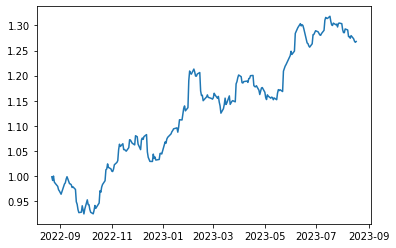

In [13]:
plt.plot(portfolio["date"],portfolio["pv"])

In [16]:
all_ledgers = pd.concat(ledgers)

In [17]:
all_ledgers.groupby(["strategy","GICS Sector"]).mean().reset_index().sort_values("actual_returns",ascending=False)

,strategy,GICS Sector,actual_returns,position
31,strategy_wsrp_wsrc_wsrr_b_r,Real Estate,1.015599,4.666667
42,strategy_wswp_wsrc_wsrr_b_r,Real Estate,1.015176,5.750000
22,strategy_wsrp_wsrc_wsrr_b_r,Communication Services,1.013585,4.205882
29,strategy_wsrp_wsrc_wsrr_b_r,Information Technology,1.012708,3.914286
39,strategy_wswp_wsrc_wsrr_b_r,Industrials,1.012354,5.188679
28,strategy_wsrp_wsrc_wsrr_b_r,Industrials,1.011937,5.000000
23,strategy_wsrp_wsrc_wsrr_b_r,Consumer Discretionary,1.009849,3.835821
27,strategy_wsrp_wsrc_wsrr_b_r,Health Care,1.008289,4.166667
33,strategy_wswp_wsrc_wsrr_b_r,Communication Services,1.007846,4.246914
38,strategy_wswp_wsrc_wsrr_b_r,Health Care,1.007781,4.018182
